In [1]:
import requests

url = "https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv"
response = requests.get(url)

if response.status_code == 200:
    with open("housing.csv", "wb") as f:
        f.write(response.content)
    print("File 'housing.csv' downloaded successfully.")
else:
    print(f"Failed to download file. Status code: {response.status_code}")


File 'housing.csv' downloaded successfully.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly as px

df = pd.read_csv('/Users/home/MLZoomcamp/Week_2/housing.csv')

In [3]:
df.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity'],
      dtype='object')

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


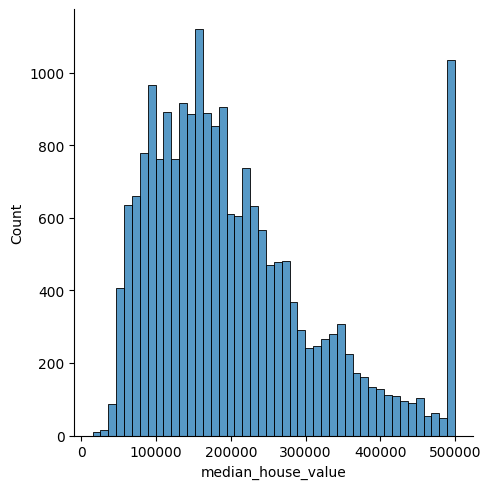

In [4]:
data = df.median_house_value
sns.displot(df, x = 'median_house_value')

In [5]:
filtered_data =df[df['ocean_proximity'].isin(['<1H OCEAN', 'INLAND'])]

# Select only the specified columns
selected_columns = [
    'latitude',
    'longitude',
    'housing_median_age',
    'total_rooms',
    'total_bedrooms',
    'population',
    'households',
    'median_income',
    'median_house_value'
]

# Create a new DataFrame with only the selected columns
subset_data = filtered_data[selected_columns]

In [6]:
df.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [7]:
subset_data.population.median()

1195.0

In [8]:
n = len(subset_data)
n_test = int(n * 0.2)
n_val = int(n * 0.2)
n_train = n - n_test - n_val

In [9]:
idx = np.arange(n)
np.random.seed(42)
np.random.shuffle(idx)

df_train = subset_data.iloc[idx[:n_train]]
df_val = subset_data.iloc[idx[n_train: n_train + n_val]]
df_test = subset_data.iloc[idx[n_train + n_val:]]

# Apply the log transformation to the median_house_value variable
# train_data['median_house_value'] = np.log1p(train_data['median_house_value'])
# val_data['median_house_value'] = np.log1p(val_data['median_house_value'])
# test_data['median_house_value'] = np.log1p(test_data['median_house_value'])


In [10]:
n_val, n_test, n_train

(3137, 3137, 9413)

In [11]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [12]:
y_train = np.log1p(df_train.median_house_value.values)
y_val = np.log1p(df_val.median_house_value.values)
y_test = np.log1p(df_test.median_house_value.values)

df_train.drop(columns='median_house_value', inplace=True, errors='ignore')
df_val.drop(columns='median_house_value', inplace=True, errors='ignore')
df_test.drop(columns='median_house_value', inplace=True, errors='ignore')

In [13]:
def with_zero(df: pd.DataFrame):
    df.fillna(0, inplace=True)
    return df

def with_mean(df: pd.DataFrame, mean: float):
    df.fillna(mean, inplace=True)
    return df

mean = df_train.total_bedrooms.mean()

df_train_zeros = with_zero(df_train)
df_val_zeros = with_zero(df_val)

df_train_mean = with_mean(df_train, mean)
df_val_mean = with_mean(df_val, mean)

In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

lr_1 = LinearRegression()
lr_2 = LinearRegression()

# for zeros
lr_1.fit(df_train_zeros, y_train)
pred = lr_1.predict(df_val_zeros)
print(np.sqrt(mean_squared_error(y_val, pred)))

# for mean
lr_2.fit(df_train_mean, y_train)
pred = lr_2.predict(df_val_mean)
print(np.sqrt(mean_squared_error(y_val, pred)))



0.34084790341714505
0.34084790341714505


In [23]:
from sklearn.linear_model import Ridge

r = [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]
best_rmse = float('inf')
best_r = None
lst = []
for item in r:
    ridge = Ridge(alpha=item)
    ridge.fit(df_train_zeros, y_train)
    preds = ridge.predict(df_val_zeros)
    rmse = np.sqrt(mean_squared_error(y_val, preds))
    if rmse < best_rmse:
        best_rmse = rmse
        best_r = item
    lst.append(rmse)
    print(f'For r = {item}, RMSE = ', np.sqrt(mean_squared_error(y_val, preds)))

print(best_r)

For r = 0, RMSE =  0.340847903417146
For r = 1e-06, RMSE =  0.34084790341890686
For r = 0.0001, RMSE =  0.3408479035932595
For r = 0.001, RMSE =  0.3408479051782897
For r = 0.01, RMSE =  0.3408479210292869
For r = 0.1, RMSE =  0.34084807960899155
For r = 1, RMSE =  0.34084967237260444
For r = 5, RMSE =  0.3408569038465673
For r = 10, RMSE =  0.3408662900969502
0


In [29]:
seeds = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
scores = []
for seed in seeds:
    idx = np.arange(n)
    np.random.seed(seed)
    np.random.shuffle(idx)

    df_train = subset_data.iloc[idx[:n_train]]
    df_val = subset_data.iloc[idx[n_train: n_train + n_val]]
    df_test = subset_data.iloc[idx[n_train + n_val:]]

    lr_1.fit(df_train_zeros, y_train)
    pred = lr_1.predict(df_val_zeros)
    print(np.sqrt(mean_squared_error(y_val, pred)))
    scores.append(np.sqrt(mean_squared_error(y_val, pred)))


std_deviation = np.std(scores)


print("Standard Deviation of RMSE Scores:", round(std_deviation, 5))

0.34084790341714505
0.34084790341714505
0.34084790341714505
0.34084790341714505
0.34084790341714505
0.34084790341714505
0.34084790341714505
0.34084790341714505
0.34084790341714505
0.34084790341714505
Standard Deviation of RMSE Scores: 0.0


In [36]:
def dot(xi, w):
    n = len(xi)
    
    res = 0.0
    
    for j in range(n):
        res = res + xi[j] * w[j]
    
    return res

def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    
    return w_full[0], w_full[1:]

def rmse(y, y_pred):
    se = (y - y_pred) ** 2
    mse = se.mean()
    return np.sqrt(mse)

seeds = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
scores = []

for seed in seeds:
    idx = np.arange(n)
    np.random.seed(seed)
    np.random.shuffle(idx)

    df_train = subset_data.iloc[idx[:n_train]]
    df_val = subset_data.iloc[idx[n_train: n_train + n_val]]
    df_test = subset_data.iloc[idx[n_train + n_val:]]

    w0, w = train_linear_regression(df_train_zeros, y_train)

    y_pred = w0 + df_val_zeros.dot(w)
    
    scores.append(rmse(y_val, y_pred))

# Calculate the standard deviation of RMSE scores
std_deviation = np.std(scores)

# Round the standard deviation to 3 decimal digits
rounded_std_deviation = std_deviation

print("Standard Deviation of RMSE Scores:", rounded_std_deviation)

Standard Deviation of RMSE Scores: 0.0


In [31]:
scores

[0.3408479034176266,
 0.3408479034176266,
 0.3408479034176266,
 0.3408479034176266,
 0.3408479034176266,
 0.3408479034176266,
 0.3408479034176266,
 0.3408479034176266,
 0.3408479034176266,
 0.3408479034176266]

In [35]:
def train_linear_regression_reg(X, y, r=0.001):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX = XTX + r * np.eye(XTX.shape[0])

    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    
    return w_full[0], w_full[1:]

r = [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]
best_rmse = float('inf')
best_r = None
lst = []
for item in r:
    w0, w = train_linear_regression_reg(df_train_zeros, y_train, r=item)
    y_pred = w0 + df_val_zeros.dot(w)
    rmse_score = rmse(y_val, y_pred)
    lst.append(rmse_score)
    print(f'For r = {item}, RMSE = {rmse_score:.5f}')

    if rmse_score < best_rmse:
        best_rmse = rmse_score
        best_r = item

print(f'Best r: {best_r}, Best RMSE: {best_rmse:.5f}')

For r = 0, RMSE = 0.34085
For r = 1e-06, RMSE = 0.34085
For r = 0.0001, RMSE = 0.34085
For r = 0.001, RMSE = 0.34085
For r = 0.01, RMSE = 0.34088
For r = 0.1, RMSE = 0.34129
For r = 1, RMSE = 0.34490
For r = 5, RMSE = 0.34774
For r = 10, RMSE = 0.34831
Best r: 0, Best RMSE: 0.34085


In [39]:
# Split the data into train/val/test sets with seed 9
idx = np.arange(n)
np.random.seed(9)
np.random.shuffle(idx)

df_train = subset_data.iloc[idx[:n_train]]
df_val = subset_data.iloc[idx[n_train: n_train + n_val]]
df_test = subset_data.iloc[idx[n_train + n_val:]]

y_train = np.log1p(df_train.median_house_value.values)
y_val = np.log1p(df_val.median_house_value.values)
y_test = np.log1p(df_test.median_house_value.values)

df_train.drop(columns='median_house_value', inplace=True, errors='ignore')
df_val.drop(columns='median_house_value', inplace=True, errors='ignore')
df_test.drop(columns='median_house_value', inplace=True, errors='ignore')

df_train_zeros = with_zero(df_train)
df_val_zeros = with_zero(df_val)
df_test_zeros = with_zero(df_test)

# Train a model with r=0.001
w0, w = train_linear_regression_reg(df_train_zeros, y_train, r=0.001)

# Make predictions on the test dataset
y_pred_test = w0 + df_test_zeros.dot(w)

# Calculate RMSE on the test dataset
rmse_test = rmse(y_test, y_pred_test)

print(f'RMSE on the test dataset: {rmse_test:.3f}')


RMSE on the test dataset: 0.335


/var/folders/yq/sbcn4y5n0zl14q1_s6x_1sbr0000gn/T/ipykernel_69993/2120802162.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.drop(columns='median_house_value', inplace=True, errors='ignore')
/var/folders/yq/sbcn4y5n0zl14q1_s6x_1sbr0000gn/T/ipykernel_69993/2120802162.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val.drop(columns='median_house_value', inplace=True, errors='ignore')
/var/folders/yq/sbcn4y5n0zl14q1_s6x_1sbr0000gn/T/ipykernel_69993/2120802162.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https:/